In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
engine.execute('SELECT * FROM Measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [14]:
result = session.query(Measurement.id, Measurement.date).order_by(Measurement.date.desc()).all()
result

[(2724, '2017-08-23'),
 (7635, '2017-08-23'),
 (12187, '2017-08-23'),
 (19550, '2017-08-23'),
 (2723, '2017-08-22'),
 (12186, '2017-08-22'),
 (19549, '2017-08-22'),
 (2722, '2017-08-21'),
 (7634, '2017-08-21'),
 (12185, '2017-08-21'),
 (19548, '2017-08-21'),
 (2721, '2017-08-20'),
 (7633, '2017-08-20'),
 (19547, '2017-08-20'),
 (2720, '2017-08-19'),
 (7632, '2017-08-19'),
 (12184, '2017-08-19'),
 (19546, '2017-08-19'),
 (2719, '2017-08-18'),
 (7631, '2017-08-18'),
 (14959, '2017-08-18'),
 (19545, '2017-08-18'),
 (7630, '2017-08-17'),
 (12183, '2017-08-17'),
 (14958, '2017-08-17'),
 (19544, '2017-08-17'),
 (7629, '2017-08-16'),
 (12182, '2017-08-16'),
 (14957, '2017-08-16'),
 (19543, '2017-08-16'),
 (2718, '2017-08-15'),
 (7628, '2017-08-15'),
 (12181, '2017-08-15'),
 (14956, '2017-08-15'),
 (19542, '2017-08-15'),
 (2717, '2017-08-14'),
 (7627, '2017-08-14'),
 (12180, '2017-08-14'),
 (14955, '2017-08-14'),
 (19541, '2017-08-14'),
 (2716, '2017-08-13'),
 (7626, '2017-08-13'),
 (12179, '2

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

precipitation = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
    

prcp_df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])
prcp_df

,date,precipitation
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000
...,...,...
361,2017-08-19,0.030000
362,2017-08-20,0.005000
363,2017-08-21,0.193333
364,2017-08-22,0.166667


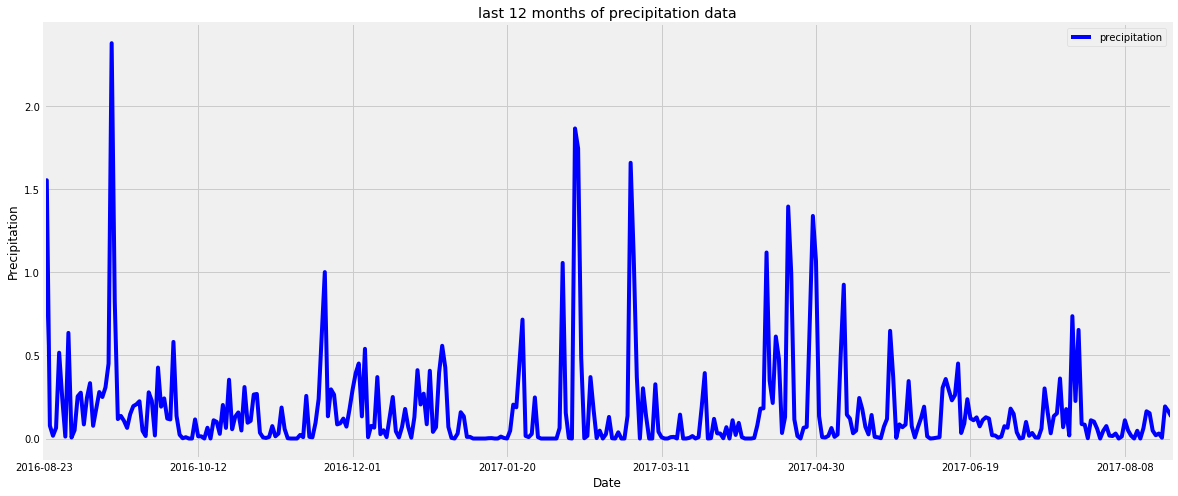

<Figure size 432x288 with 0 Axes>

In [24]:
prcp_df.plot('date','precipitation',figsize = (18,8), color="blue")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("last 12 months of precipitation data")
plt.show()


plt.savefig("Precipitation.jpg")

In [19]:
# Design a query to show how many stations are available in this dataset?
station = session.query(func.count(Station.station)).all()
station_count = station[0][0]
station_count

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
observation_count = session.query(Station.station, func.count(Measurement.station)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
observation_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


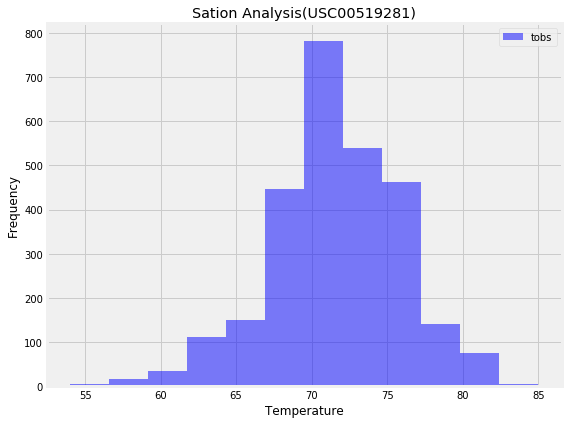

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.tobs).\
              filter(Station.station == Measurement.station).\
              filter(Station.station == 'USC00519281').all()
        
tobs_df = pd.DataFrame(temperature, columns=['tobs'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(tobs_df['tobs'], bins=12, color='blue', alpha=0.5)
ax.legend(['tobs'])
ax.set_title('Sation Analysis(USC00519281)')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig("station_analysis.png", bbox_inches='tight')
plt.show()

![precipitation](Images/station-histogram.png)

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    min_temp = session.query(func.min(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    max_temp = session.query(func.max(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    result = min_temp, max_temp, avg_temp
    return list(np.ravel(result))    
  #  return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
  #      filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[62.0, 74.0, 69.57142857142857]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-08-23'
end_date = '2017-08-23'
[min_temp, avg_temp, max_temp] = calc_temps(start_date, end_date)

print(f"My trip starts on {start_date} and ends on {end_date}. \
For the range of dates, the min temperature is {min_temp}, \
mean temperature is {avg_temp}, and maximum temperature is {max_temp}.")

My trip starts on 2016-08-23 and ends on 2017-08-23. For the range of dates, the min temperature is 58.0, mean temperature is 87.0, and maximum temperature is 74.59058295964125.


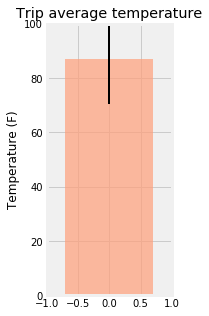

In [42]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(0, avg_temp, color="lightsalmon", width=1.4, 
        alpha=0.7, yerr=max_temp-min_temp, error_kw={"linewidth":2})
plt.xlim((-1, 1))
plt.ylim((0, 100))
plt.ylabel("Temperature (F)")
plt.title("Trip average temperature")
plt.savefig('temp_avg.png', bbox_inches="tight", dpi = 300)

In [43]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')

session.query(Measurement.station, func.avg(Measurement.prcp)). \
            filter(Measurement.date.between(start_date_dt, end_date_dt)). \
            group_by(Measurement.station). \
            order_by(func.avg(Measurement.prcp).desc()).all()

[('USC00516128', 0.4498776758409787),
 ('USC00519281', 0.1944159544159545),
 ('USC00513117', 0.1414035087719299),
 ('USC00514830', 0.12571969696969695),
 ('USC00519523', 0.12137380191693291),
 ('USC00517948', 0.0765),
 ('USC00519397', 0.04494413407821225)]

## Optional Challenge Assignment

In [3]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    

In [4]:
daily_normals("02-01")

NameError: name 'func' is not defined

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
